Théo Ripoll - Bastien Pouessel - Tom Genlis - Quentin Fisch - Arnaud Baradat

# Rapport Very Large Graph

## Clique Finding Algorithms Benchmark Analysis

### 1. Graph Representation using networkx

We will be using the NetworkX library for graph representation.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from more_itertools import powerset
import time
import pickle
import numpy as np
import pyspark as ps
import tqdm
from tqdm import tqdm, trange
from matplotlib.ticker import ScalarFormatter
import threading
import queue
import os
from concurrent.futures import ThreadPoolExecutor, as_completed

Using NetworkX, we will be able to easily proceduraly generate random graphs with a set number of nodes and a set probability of edges, using the Erdos-Renyi algorithm provided by NetworkX.

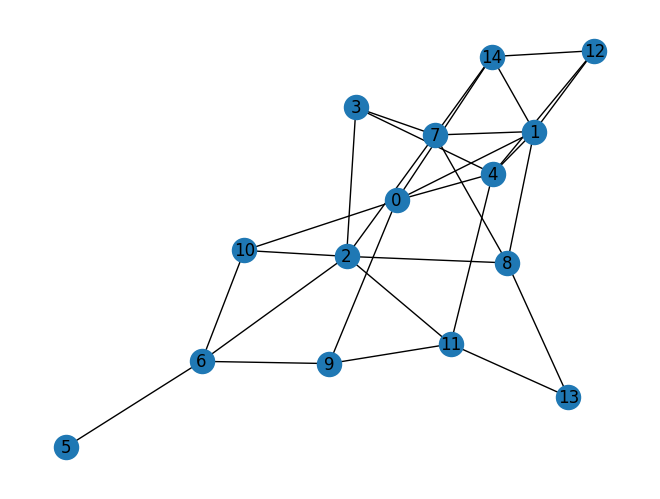

In [2]:
G = nx.erdos_renyi_graph(15, 0.3, seed=1)
nx.draw(G, with_labels=True)
plt.show()

We next delve into the realm of clique finding algorithms, focusing on the contrast between non-parallelized and parallelized approaches.

Non-parallelized algorithms, such as the Naive, Bron Kerbosch, and its variants, operate sequentially and are typically simpler but can be slower for large datasets.

Conversely, parallelized methods, which we will explore through enhanced versions of the Bron Kerbosch algorithm, leverage concurrent processing to improve efficiency, particularly in handling large-scale graph data.

### 2. No Parallelization

#### 2.1 Naive Implementation


In this section, we implement a basic, straightforward approach to find cliques in a graph. This method, termed as the 'Naive' algorithm, involves a simplistic and direct strategy without incorporating any advanced optimizations or heuristics. The goal here is to establish a baseline understanding of the problem and to have a reference point for the performance of more complex algorithms.

Here's the pseudocode implementation of the Naive algorithm:

```python
fonction recherche_clique(graphe G):
    n = nombre de sommets de G
    taille_max_clique = 0
    clique_max = ensemble vide
    
    pour chaque sous-ensemble S de sommets de G:
        si la taille de S > taille_max_clique et est_clique(G, S):
            taille_max_clique = taille de S
            clique_max = S
            
    retourner clique_max

fonction est_clique(graphe G, ensemble S):
    pour chaque paire de sommets v, w dans S:
        si v n'est pas adjacent à w dans G:
            retourner faux
    retourner vrai
```

In [8]:
def is_clique(G, S):
    for i in S:
        for j in S:
            if i != j and not G.has_edge(i, j):
                return False
    return True

def recherche_clique_naive(G):
    taille_max_clique = 0
    clique_max = set()
    
    for S in powerset(G.nodes()):
        if len(S) > taille_max_clique and is_clique(G, S):
            taille_max_clique = len(S)
            clique_max = S
            
    return clique_max

Test on a small graph G while comparing with the NetworkX implementation:

In [36]:
start_time = time.time()
clique_max = recherche_clique_naive(G)
print("Clique max (naive):", clique_max)
print("Exec time (naive):", time.time() - start_time)
print("Is clique", is_clique(G, clique_max))
print()

start_time = time.time()
clique_max_netx = nx.approximation.max_clique(G)
print("Clique max (networkx):", clique_max_netx)
print("Exec time (networkx):", time.time() - start_time)

Clique max (naive): (0, 1, 4)
Exec time (naive): 0.010426044464111328
Is clique True

Clique max (networkx): {2, 3, 7}
Exec time (networkx): 0.0013091564178466797


Networkx find a different clique than our algorithm, but it is also a maximal clique, so no issue here. We will check our solutions using the `is_clique` function.

#### 2.2 Bron Kerbosch

This segment focuses on implementing the Bron Kerbosch algorithm, a classic method for finding maximal cliques in a graph. Unlike its optimized versions, this implementation does not incorporate pivoting. The Bron Kerbosch algorithm is a recursive, backtracking approach known for its efficiency in identifying all maximal cliques within a graph. This implementation serves as a stepping stone to understanding more complex variations of the algorithm.

Here's the pseudocode version of the algorithm:

```python
algorithme BronKerbosch1(R, P, X)
    si P et X sont vides alors
        déclarer que R est une clique maximale
    pour tout sommet v dans P faire
        BronKerbosch1(R ⋃ {v}, P ⋂ N(v), X ⋂ N(v))
        P := P \ {v}
        X := X ⋃ {v}

BronKerbosch1(∅, V, ∅) //appel initial
```

In [6]:
def bron_kerbosh1(R, P, X, G):
    if not P and not X:
        return [R]
    else:
        cliques = []
        for v in P.copy():
            N = G.neighbors(v)
            cliques.extend(
                bron_kerbosh1(
                    R.union({v}),
                    P.intersection(N),
                    X.intersection(N),
                    G,
                )
            )
            P.remove(v)
            X.union({v})
        return cliques

def search_clique_bron_kerbosh1(G):
    return max(bron_kerbosh1(set(), set(G.nodes()), set(), G), key=len)

Test on a small graph G while comparing with the NetworkX implementation:

In [7]:
start_time = time.time()
clique_max = search_clique_bron_kerbosh1(G)
print("Clique max (bron_kerbosh1):", clique_max)
print("Exec time (bron_kerbosh1):", time.time() - start_time)
print("Is clique", is_clique(G, clique_max))

Clique max (bron_kerbosh1): {0, 1, 4}
Exec time (bron_kerbosh1): 0.0002491474151611328
Is clique True


We already see a factor 100 on the execution time, but let's compare the methods later.

#### 2.3 Bron Kerbosch Pivot


In this part of our analysis, we enhance the basic Bron Kerbosch algorithm by incorporating a pivoting mechanism. Pivoting significantly optimizes the algorithm's performance by reducing the number of recursive calls needed to find maximal cliques. This version of the algorithm strategically chooses a 'pivot' vertex to minimize the search space, thereby improving the efficiency of clique finding in larger or more complex graphs.

Here's the pseudocode version of the algorithm.

```python
algorithme BronKerbosch2(R, P, X)
    si P et X sont vides alors
        déclarer que R est une clique maximale
    choisir un sommet pivot u dans P ⋃ X
    pour tout sommet v dans P \ N(u) faire
        BronKerbosch2(R ⋃ {v}, P ⋂ N(v), X ⋂ N(v))
        P := P \ {v}
        X := X ⋃ {v}
```

In [11]:
def bron_kerbosh2(R, P, X, G):
    if not P and not X:
        return [R]
    pivot = P.union(X).pop()
    pivot = max(P.union(X), key=G.degree)
    N = G.neighbors(pivot)
    cliques = []
    for v in P.difference(N):
        N_v = G.neighbors(v)
        cliques.extend(
            bron_kerbosh2(
                R.union({v}),
                P.intersection(N_v),
                X.intersection(N_v),
                G,
            )
        )
        P.remove(v)
        X.union({v})

    return cliques

def search_clique_bron_kerbosh2(G):
    return max(bron_kerbosh2(set(), set(G.nodes()), set(), G), key=len)

Test on a small graph G while comparing with the NetworkX implementation:

In [9]:
start_time = time.time()
clique_max = search_clique_bron_kerbosh2(G)
print("Clique max (bron_kerbosh2):", clique_max)
print("Exec time (bron_kerbosh2):", time.time() - start_time)
print("Is clique", is_clique(G, clique_max))

Clique max (bron_kerbosh2): {0, 1, 4}
Exec time (bron_kerbosh2): 0.0003330707550048828
Is clique True


This implementation is a bit slower than the previous one, but the order of magnitude is the same.

#### 2.4 Bron Kerbosch Pivot and Degenerescence


The next step in our exploration of clique-finding algorithms involves further optimizing the Bron Kerbosch algorithm by incorporating degeneracy ordering. This method enhances the efficiency of the algorithm by ordering the vertices in a way that reduces the search space more effectively than the standard Bron Kerbosch algorithm, even with pivoting. The concept of degeneracy ordering is based on the principle of processing vertices with the smallest degree first, thereby simplifying the problem progressively.

Here's the pseudocode version of the algorithm.

```python
algorithme BronKerbosch3(G)
    P = V(G)
    R = Ø
    X = Ø
    pour tout sommet v visités dans un ordre de dégénérescence de G faire
        BronKerbosch2({v}, P ⋂ N(v), X ⋂ N(v))
        P := P \ {v}
        X := X ⋃ {v}
```

Description the degenerescence ordering.
- Initialiser la liste de sortie L à la liste vide.
- Calculer une valeur dv pour chaque sommet v de G, qui est le nombre de voisins de v qui n'est pas déjà dans L (initialement, il s'agit donc du degré des sommets dans G).
- Initialiser un tableau D tel que D[i] contienne la liste des sommets v qui ne sont pas déjà dans L pour lesquels dv = i.
- Initialiser la valeur k à 0.
- Répéter n fois:
    - Parcourir les cellules du tableau D[0], D[1], ... jusqu'à trouver un i pour lequel D[i] est non-vide.
    - Mettre k à max(k,i).
    - Sélectionner un sommet v de D[i], ajouter v en tête de L et le retirer de D[i].
    - Pour chaque voisin w de v qui n'est pas déjà dans L, retirer une unité de dw et déplacer w de la cellule de D correspondant à la nouvelle valeur de dw.

In [7]:
def degen(G):
    ordering = []
    deg = dict(G.degree())
    while deg:
        v = min(deg, key=deg.get)
        ordering.append(v)
        del deg[v]
        for w in G.neighbors(v):
            if w in deg:
                deg[w] -= 1
    return ordering


def bron_kerbosh3(G):
    R = set()
    P = set(G.nodes())
    X = set()
    cliques = []
    for v in degen(G):
        N = G.neighbors(v)
        cliques.extend(
            bron_kerbosh2(
                R.union({v}),
                P.intersection(N),
                X.intersection(N),
                G,
            )
        )
        P.remove(v)
        X.union({v})
    return cliques

def search_clique_bron_kerbosh3(G):
    return max(bron_kerbosh3(G), key=len)

Test on a small graph G while comparing with the NetworkX implementation.

In [11]:
start_time = time.time()
clique_max = search_clique_bron_kerbosh3(G)
print("Clique max (bron_kerbosh3):", clique_max)
print("Exec time (bron_kerbosh3):", time.time() - start_time)
print("Is clique", is_clique(G, clique_max))

Clique max (bron_kerbosh3): {2, 3, 7}
Exec time (bron_kerbosh3): 0.0002799034118652344
Is clique True


Using this method, a different clique is found, and it is also the same as networkx. Also, we stay in the same order of magnitude. Up until now, our functions found a valid solution, which is a good sign. Let's go further.

### 2.5 Benchmark and Analysis

Now, let's compare the performance of the different algorithms we have implemented on a range of graphs of increasing node sizes. We will then run each algorithm on these graphs and compare their performance on a graph.

In [3]:
def generate_random_graph(node_count, edge_prob):
    """
    Generates a random graph with a given number of nodes and probability of edge creation.
    """
    return nx.erdos_renyi_graph(node_count, edge_prob)

def benchmark_clique_search_functions(functions, node_counts, edge_prob=0.5):
    """
    Benchmarks a list of clique search functions on randomly generated graphs with varying node counts.
    Plots the execution time of each function against the node count.
    """
    # Store execution times for each function and node count
    execution_times = {func.__name__: [] for func in functions}

    for node_count in tqdm(node_counts):
        # Generate a random graph
        G = generate_random_graph(node_count, edge_prob)

        for func in functions:
            start_time = time.time()
            if node_count > 15 and (func.__name__ == 'recherche_clique_naive' or func.__name__ == 'recherche_clique_naive_pool'):
                execution_times[func.__name__].append(float('inf'))
                continue

            func(G)  # Execute the function with the graph
            end_time = time.time()

            # Calculate and store the execution time
            execution_times[func.__name__].append(end_time - start_time)

    return execution_times

In [17]:
functions = [
    recherche_clique_naive,
    search_clique_bron_kerbosh1,
    search_clique_bron_kerbosh2,
    search_clique_bron_kerbosh3
]

node_counts = np.unique(np.power(1.34, np.arange(1, 20)).astype(int))
print(node_counts)

[  1   2   3   4   5   7  10  13  18  25  33  44  60  80 108 144 194 260]


We will benchmark using these number of nodes, so that we can compare the algorithms on different scales.

The code below can be used to generate the benchmark output without running the algorithms again.

In [14]:
# load execution times

# with open('execution_times.pickle', 'rb') as f:
#     execution_times = pickle.load(f)

In [ ]:
execution_times = benchmark_clique_search_functions(functions, node_counts)

In [ ]:
# save execution times

with open('execution_times.pickle', 'wb') as f:
    pickle.dump(execution_times, f)

In [6]:
def benchmark_plotting(node_counts, execution_times):
    fig, ax = plt.subplots(figsize=(10, 6))
    for func_name, times in execution_times.items():
        plt.plot(node_counts, times, label=func_name)
    
    plt.yscale('log')
    plt.xscale('log', base=1.34)
    for axis in [ax.xaxis, ax.yaxis]:
        s = ScalarFormatter()
        s.set_scientific(False)
        axis.set_major_formatter(s)
    
    plt.xticks(node_counts[1:])
    plt.xlim(node_counts[5] / 1.5, node_counts[-1] * 1.5)

    plt.xlabel('Node Count')
    plt.ylabel('Execution Time (seconds)')
    plt.title('Clique Search Function Benchmarks')
    plt.legend()
    plt.grid(True)
    plt.show()

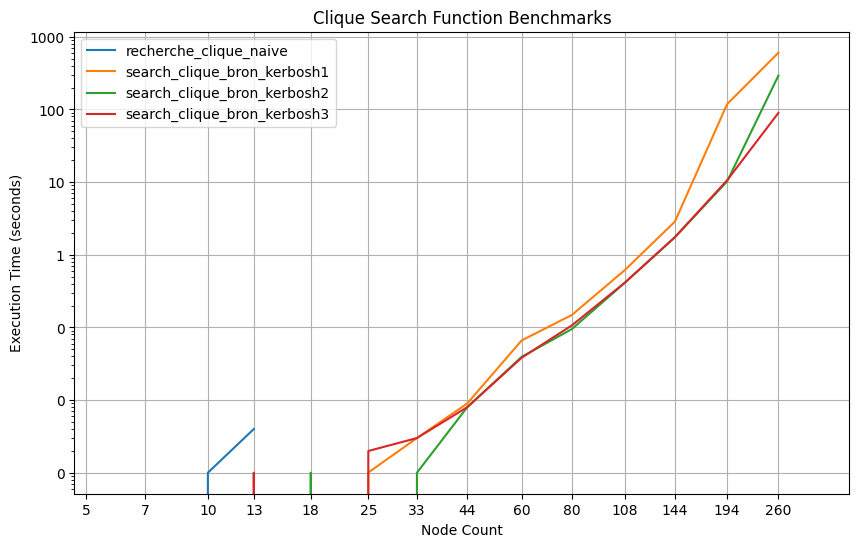

In [19]:
benchmark_plotting(node_counts, execution_times)

Here is our first benchmark plot.
- Firstly, let's note that the naive algorithm is not represented here, as it is too slow to be run on graphs of size > 15. So we consider it out of the competition, which makes perfect sense.
- All three Bron Kerbosch algorithms have a similar execution time, which is expected as they are all based on the same principle. The degenerescence ordering is a bit faster on the biggest graph, but the difference is not significant with the first pivot algorithm. The second pivot algorithm is a bit slower, but the difference is not significant either.

Bron Kerbosch methods are really faster than the naive algorithm, but they are still too slow to be used on big graphs. Let's try to parallelize them.

### 3. Parallelization


#### 3.1 Selection of Algorithm for Parallelization


In our analysis of various clique-finding algorithms, the Bron Kerbosch algorithm with pivoting and degeneracy ordering emerged as the best performing non-parallelized method.

This decision to parallelize this specific version was driven by its superior performance in previous benchmarks. The inclusion of both pivoting and degeneracy ordering in this algorithm significantly improved its efficiency, making it the ideal candidate for parallelization. Pivoting reduced the search space dramatically, while degeneracy ordering ensured an even more efficient exploration of the graph. These features not only enhanced its performance in terms of speed but also reduced computational complexity, making it the most promising version for adapting into a parallelized framework.

The aim is to leverage these inherent efficiencies while scaling up the algorithm's capability to handle larger and more complex graphs through parallel processing.

#### 3.2 Multithread


In this phase of our study, we focus on implementing a multithreaded version of the Bron Kerbosch algorithm with pivoting and degeneracy ordering. The objective here is to adapt the algorithm to run across multiple threads, thereby dividing the workload and potentially speeding up the process. Multithreading allows different parts of the algorithm to execute concurrently, making use of available CPU cores. This approach aims to harness the power of modern multi-core processors to enhance the performance of the clique finding task, especially beneficial when dealing with large and complex graphs.

However in Python, multithreading is not efficient because of the Global Interpreter Lock (GIL) which prevents multiple threads from executing Python bytecodes at once. This means that multithreading is not the best approach to parallelize Python code, but it is still interesting to see the performance difference.

#### 3.2.A Naive

In [19]:
def is_clique(G, S):
    for i in S:
        for j in S:
            if i != j and not G.has_edge(i, j):
                return (False, S, 0)
    return (True, S, len(S))

def wrapper(arg):
    return is_clique(*arg)

def recherche_clique_naive_pool(G):
    taille_max_clique = 0
    clique_max = set()
    
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        futures = [executor.submit(wrapper, (G, S)) for S in powerset(G.nodes())]
        for future in as_completed(futures):
            l = future.result()[2]
            S = future.result()[1]
            if l > taille_max_clique:
                taille_max_clique = l
                clique_max = S
            
    return clique_max

#### 3.2.B Bron Kerbosch Pivot and Degenerescence

In [20]:
def bron_kerbosh3_pool(G):
    R = set()
    P = set(G.nodes())
    X = set()
    cliques = []
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        futures = [executor.submit(bron_kerbosh2, R.union({v}), P.intersection(G.neighbors(v)), X.intersection(G.neighbors(v)), G) for v in degen(G)]
        for future in tqdm(as_completed(futures)):
            cliques.extend(future.result())
    return cliques

def search_clique_bron_kerbosh3_pool(G):
    return max(bron_kerbosh3_pool(G), key=len)

In [41]:
clique_max = search_clique_bron_kerbosh3_pool(G)
print("Clique max (bron_kerbosh3):", clique_max)
print("Is clique", is_clique(G, clique_max))

15it [00:00, 94466.31it/s]

Clique max (bron_kerbosh3): {0, 1, 4}
Is clique True


In [22]:
# load execution times pool

# with open('execution_times_pool.pickle', 'rb') as f:
#     execution_times_pool = pickle.load(f)

In [23]:
functions_pool = [
    recherche_clique_naive_pool,
    search_clique_bron_kerbosh3_pool
]
execution_times_pool = benchmark_clique_search_functions(functions_pool, node_counts)

1it [00:00, ?it/s]/18 [00:00<?, ?it/s]
2it [00:00, ?it/s]
3it [00:00, ?it/s]
4it [00:00, ?it/s]
5it [00:00, 623.78it/s]
7it [00:00, ?it/s]
10it [00:00, ?it/s]
13it [00:00, ?it/s]18 [00:00<00:00, 40.49it/s]
18it [00:00, ?it/s]
25it [00:00, 23595.32it/s]
33it [00:00, ?it/s]
44it [00:00, ?it/s]
60it [00:00, ?it/s]/18 [00:00<00:00, 15.78it/s]
80it [00:00, ?it/s]
108it [00:00, 288.07it/s]
144it [00:12, 11.89it/s]00:15<00:01,  2.11it/s]
194it [01:45,  1.84it/s]00:21<00:04,  2.49s/it]
260it [11:42,  2.70s/it]02:14<00:19, 19.30s/it]
100%|██████████| 18/18 [14:23<00:00, 47.95s/it] 


In [24]:
# save execution times

with open('execution_times_pool.pickle', 'wb') as f:
    pickle.dump(execution_times_pool, f)

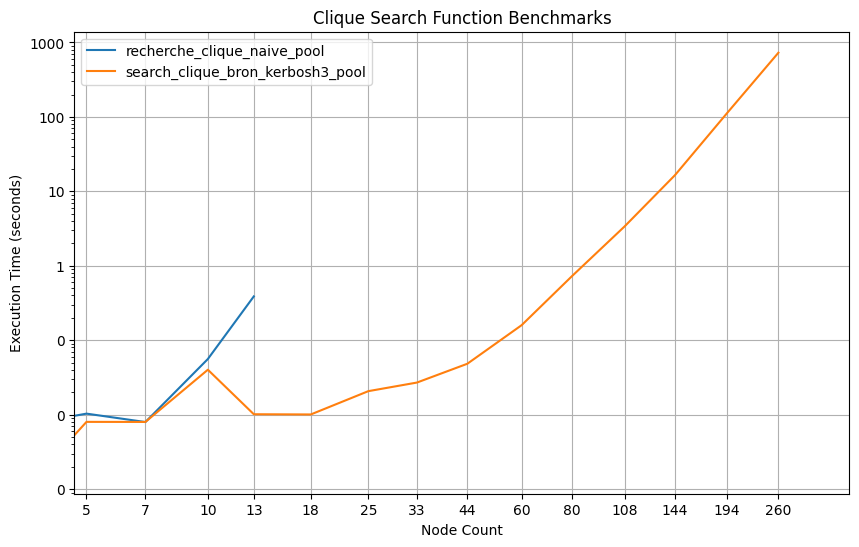

In [25]:
benchmark_plotting(node_counts, execution_times_pool)

Once again, this time with threading methods, Bron Kerbosch is much faster than the naive algorithm, which had to be stopped earlier. Let's now compare threaded and standard methods.

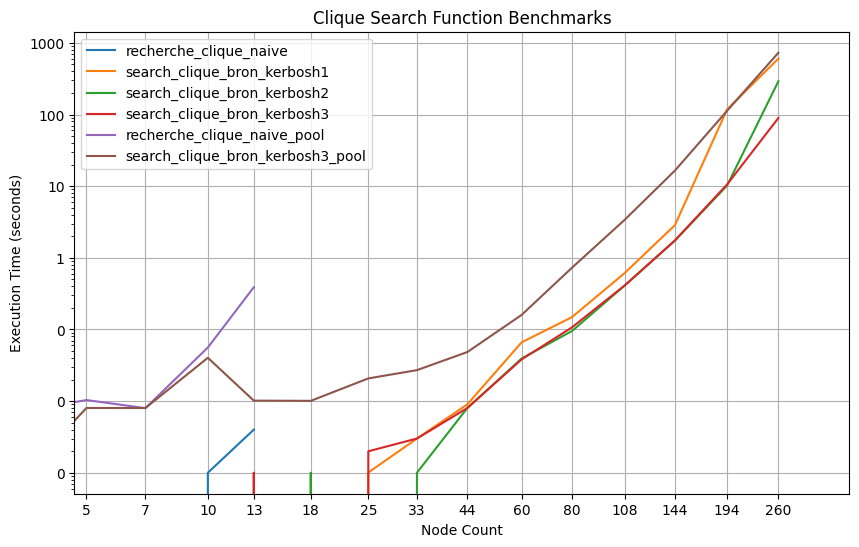

In [26]:
total_execution_times = {}
for func_name, times in execution_times.items():
    total_execution_times[func_name] = times
for func_name, times in execution_times_pool.items():
    total_execution_times[func_name] = times

benchmark_plotting(node_counts, total_execution_times)

Here we find the same results as before, but the threaded methods are slower. This is due to the GIL, which we talked about earlier. Let's try to parallelize the algorithms using spark instead.

#### 3.3 PySpark Local


In this step of the project, we adapt the Bron Kerbosch algorithm with pivoting and degeneracy ordering to run on a local PySpark setup.

PySpark, the Python API for Apache Spark, offers a robust framework for distributed computing, allowing us to scale the algorithm beyond the limitations of single-machine processing. By migrating the algorithm to PySpark, we aim to distribute the computational tasks across multiple nodes, even in a local environment.

This adaptation is crucial for handling larger datasets and more complex graph structures, where the computational load can be significant. Utilizing PySpark's capabilities, such as resilient distributed datasets (RDDs) and its distributed processing engine, we can potentially achieve greater efficiency and scalability.

The focus here is not only on parallelizing the algorithm but also on optimizing it for a distributed computing environment, leveraging PySpark's tools and features for effective large-scale data processing.

In [5]:
def bron_kerbosch_pivot(R, P, X, G):
    if not P and not X:
        return [R]
    else:
        cliques = []
        pivot = max(P.union(X), key=G.degree)
        for v in P.copy().difference(set(G.neighbors(pivot))):
            N = set(G.neighbors(v))
            cliques += bron_kerbosch_pivot(
                R.union({v}),
                P.intersection(N),
                X.intersection(N),
                G
            )

            P.remove(v)
            X.add(v)
        
        return cliques

def bron_kerbosch_map(G):
    map = [set(G.neighbors(v)).union({v}) for v in G.nodes()]
    return [set(s) for s in map]

def bron_kerbosch_reduce(x, y):
    return max(x, y, key=len)

def search_clique_bron_kerbosh3_spark(G):
    try:
        sc = ps.SparkContext('local[*]')

        rdd = sc.parallelize(bron_kerbosch_map(G))\
                .flatMap(lambda x: bron_kerbosch_pivot(set(), x, set(), G))\
                .reduce(bron_kerbosch_reduce)
        sc.stop()
        return rdd
    except Exception as e:
        print(e)
        sc.stop()

In [ ]:
# load execution times pool

# with open('execution_times_spark.pickle', 'rb') as f:
#     execution_times_spark = pickle.load(f)

In [43]:
execution_times_spark = benchmark_clique_search_functions([search_clique_bron_kerbosh3_spark], node_counts)

100%|██████████| 18/18 [02:40<00:00,  8.91s/it]                                 


In [28]:
# save execution times

with open('execution_times_spark.pickle', 'wb') as f:
    pickle.dump(execution_times_spark, f)

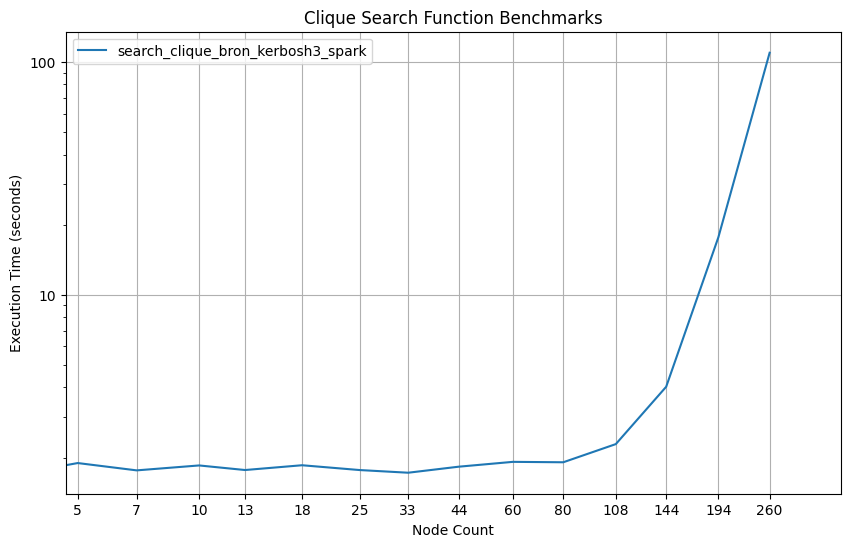

In [44]:
benchmark_plotting(node_counts, execution_times_spark)

This plot only shows the execution time of the PySpark method (last Bron Kerbosch version). We need to put this graph in perspective with the previous ones.

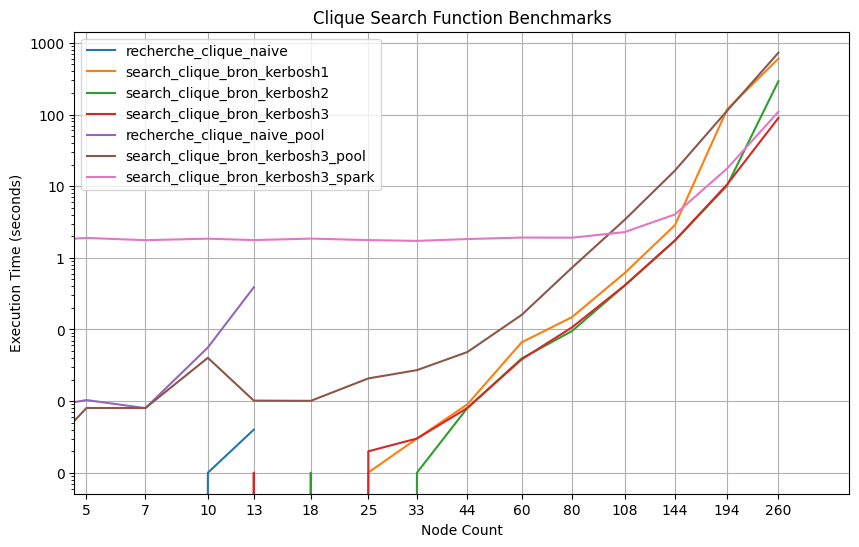

In [45]:
total_execution_times = {}
for func_name, times in execution_times.items():
    total_execution_times[func_name] = times
for func_name, times in execution_times_pool.items():
    total_execution_times[func_name] = times
for func_name, times in execution_times_spark.items():
    total_execution_times[func_name] = times

benchmark_plotting(node_counts, total_execution_times)

More interesting results here. As expeccted, the PySpark implementation is slower with small graphs, but it looks faster with bigger graphs. This is due to the fact that the overhead of the parallelization is not worth it for small graphs, but it is for bigger graphs. We tried to benchmark on bigger graphs but the kernel just can't handle it. However, looking at the slope of both the pink and red curves, we can see that the PySpark implementation is faster than the standard one for graphs of size > 100. This is a good sign, and we can expect the PySpark implementation to be faster on bigger graphs.

#### 3.4 PySpark Cluster


The next progression in our analysis involves scaling the PySpark implementation to run on a cluster. This step is crucial for harnessing the full potential of distributed computing.

This stage's performances are hard to show, and we don't have clear results, but very interesting things happenend during the implementation.
- Firstly, we have only 3 machines that could work together (the last 2 were struggling with the environment), so we couldn't test on a lot of machines.
- Then, we have very different architectures: intel i7 processor, Apple M1 chip, Apple with intel i5 processor, so we couldn't test on a homogeneous cluster. This means that the results are not very relevant in some cases. For example, we tested on a graph with 200 nodes, and the Apple M1 chip was more than 2 times faster than the intel i7 processor, which is very unmbalanced.
- We were only able to distribute our work on 2 CPU cores per machine, which is pretty sad.

These points show some instability and really crucial bias for a benchmark. However, everything is not dark, and we were able to see some interesting things. On a large graph of 600 nodes, we took (3 machines) 6mins 30s to find the maximal cliques, which is pretty good. The Apple M1 chip was stopped at 10mins without finding the maximal cliques, so we can see some advantages of clustering. With smaller graphs however, using only one computer was faster than the cluster, which is not surprising.

We couldn't run more test, which is a shame, but the results are still interesting.

### 4. Conclusion

To summarize the results we have found, we can say that parallelizing graphs is not trivial. Indeed, we have seen that the overhead of parallelization is not worth it for small graphs, but it is for bigger graphs. We have also seen that the GIL is a real problem for parallelization in Python, and that we should use other languages for parallelization. Finally, we have seen that clustering is a good way to parallelize graphs, but it is not easy to set up, and it is not always worth it. Also, the naive implementation to find the maximal cliques is not efficient at all, and we should use more complex algorithms like Bron Kerbosch and its variants.

We could go further with bigger graphs for better comparision, but the main improvement would be to use a real cluster with more machines and a more homogeneous architecture. Our cluster setup was far from optimal and surely didn't depict the real performance of clustering. This is a shame, but we were not able to do better.